# Benchmark Data Visualization
This notebook compares EC and Replication benchmark results for `success_performance.med`, `success_performance.p(90)`, and `reqs.rate`.

For better visualization, it generates:
- One chart for each metric (med, p90, reqs.rate), comparing EC and Replication for each payload size and virtual user combination.

In [1]:
import json
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your benchmark results directory
results_dir = './results/'
ec_pattern = results_dir + 'erasure/_system_*_*.json'
replication_pattern = results_dir + 'replication/_system_*_*.json'

# Helper to extract data from files

def extract_data(files, system_type):
    data = []
    for file in files:
        # Updated regex to extract bandwidth as well
        match = re.search(r'_system_(.+?)_(\d+)vu(?:_(\d+kbit))?\.json', file)
        if not match:
            continue
        payload_size = match.group(1)
        if payload_size.endswith('b'):
            payload_size = payload_size[:-1]
        try:
            payload_size = int(payload_size)
        except ValueError:
            pass
        virtual_user = match.group(2)
        bandwidth = match.group(3) if match.group(3) else 'unlimited'
        with open(file) as f:
            j = json.load(f)
            try:
                med = j['summary']['success_performance'].get('med', 0)
                p90 = j['summary']['success_performance'].get('p(90)', 0)
                avg = j['summary']['success_performance'].get('avg', 0)
            except (KeyError, TypeError):
                med = 0
                p90 = 0
                avg = 0
            try:
                rate = j['summary']['reqs'].get('rate', 0)
            except (KeyError, TypeError):
                rate = 0
            data.append({
                'system': system_type,
                'payload_size': payload_size,
                'virtual_user': int(virtual_user),
                'bandwidth': bandwidth,
                'med': med,
                'p90': p90,
                'avg': avg,
                'rate': rate
            })
    return data

# Collect EC and Replication data
files_ec = glob.glob(ec_pattern)
files_replication = glob.glob(replication_pattern)
data = extract_data(files_ec, 'EC') + extract_data(files_replication, 'Replication')
df = pd.DataFrame(data)
if not df.empty:
    # Sort by payload_size, virtual_user, bandwidth, then system for grouped comparison
    df = df.sort_values(['payload_size', 'virtual_user', 'bandwidth', 'system'])
    df['combo'] = df.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu_{row['bandwidth']}", axis=1)
    df.reset_index(drop=True, inplace=True)
df

,system,payload_size,virtual_user,bandwidth,med,p90,avg,rate,combo
0,EC,100000,1,200kbit,16739.807405,16993.707860,13152.814216,0.076006,100000B_1vu_200kbit
1,Replication,100000,1,200kbit,23162.623196,28802.830041,19706.386579,0.050731,100000B_1vu_200kbit
2,EC,100000,1,400kbit,8452.045802,9412.064513,7599.100544,0.131517,100000B_1vu_400kbit
3,Replication,100000,1,400kbit,13671.786114,13851.631168,10089.468219,0.099057,100000B_1vu_400kbit
4,EC,100000,1,600kbit,5649.827229,9585.744334,6185.669872,0.161565,100000B_1vu_600kbit
5,Replication,100000,1,600kbit,9397.295302,9889.175874,7710.329554,0.129618,100000B_1vu_600kbit
6,EC,100000,1,800kbit,4253.545668,7465.126727,4719.547701,0.211654,100000B_1vu_800kbit
7,Replication,100000,1,800kbit,6962.549266,10124.531018,6872.652101,0.145422,100000B_1vu_800kbit


/tmp/ipykernel_335469/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


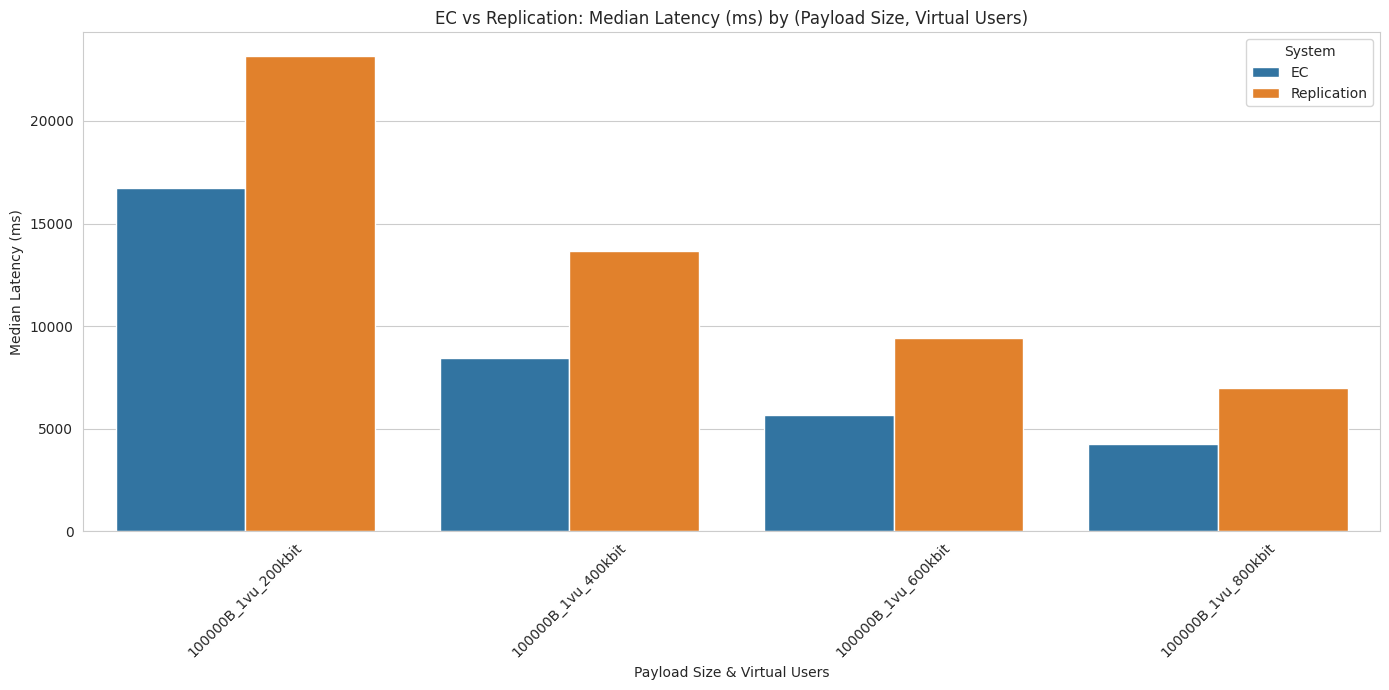

/tmp/ipykernel_335469/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


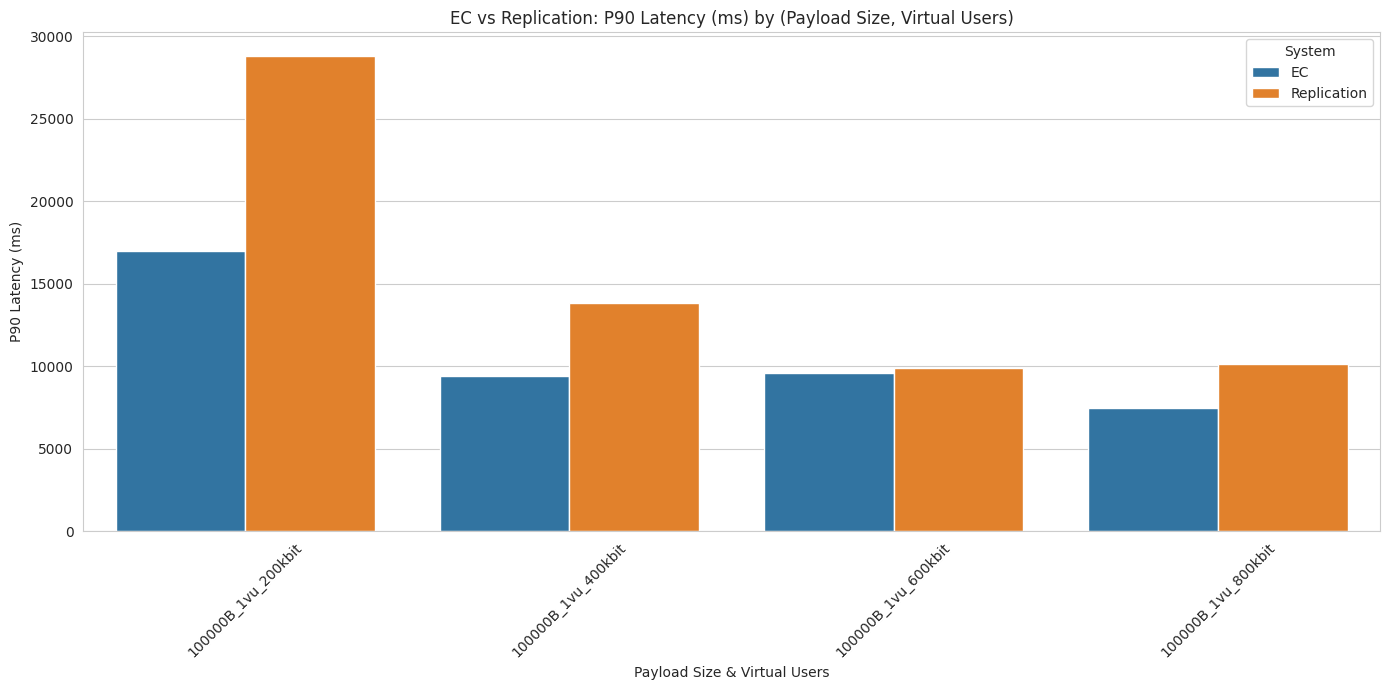

/tmp/ipykernel_335469/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


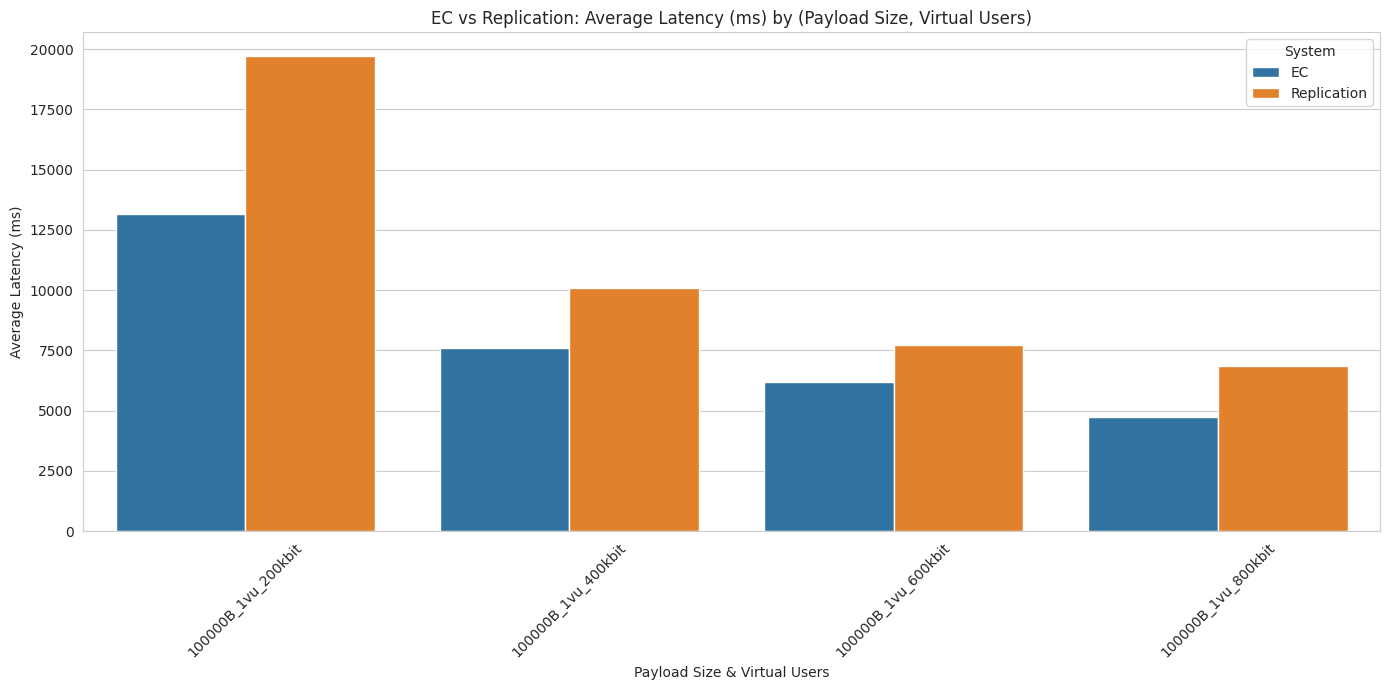

/tmp/ipykernel_335469/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


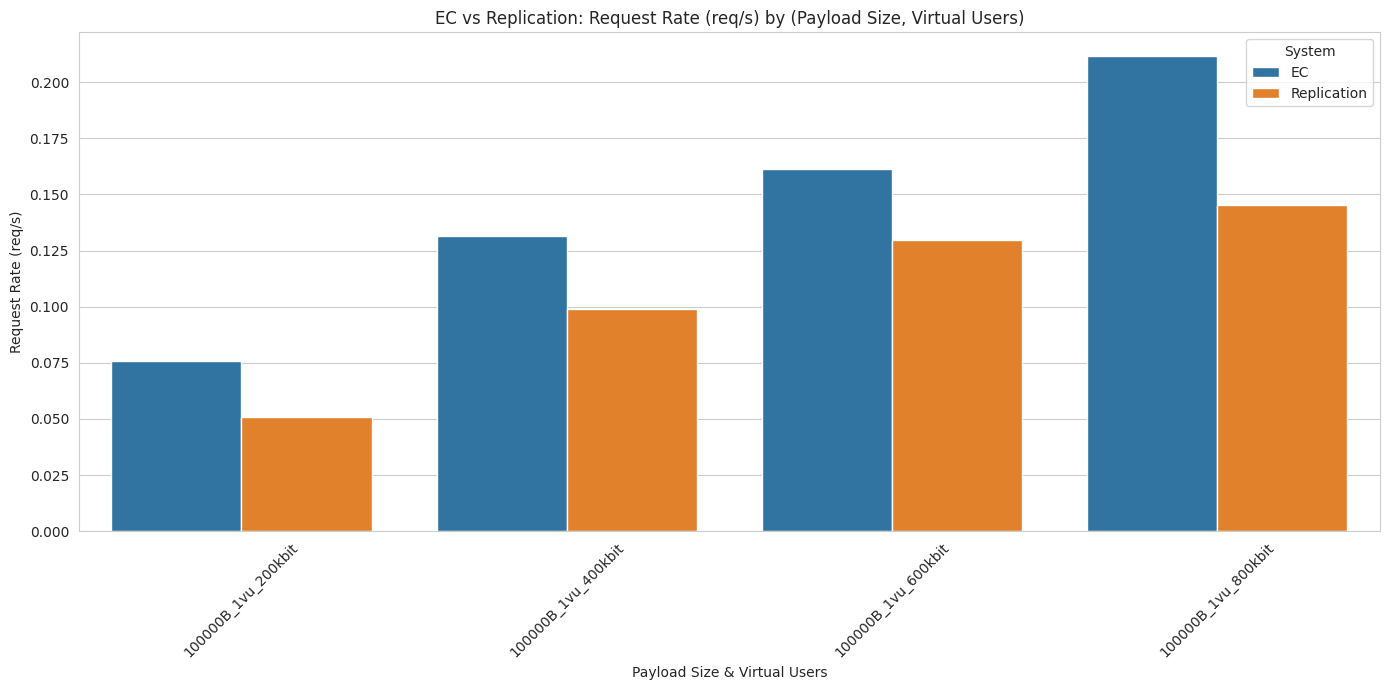

In [2]:
# Plotting: Compare EC vs Replication for each metric, grouped by (payload_size, virtual_user)
sns.set_style("whitegrid")
metrics = ['med', 'p90', 'avg', 'rate']
metric_titles = {'med': 'Median Latency (ms)', 'p90': 'P90 Latency (ms)', 'avg': 'Average Latency (ms)', 'rate': 'Request Rate (req/s)'}

for metric in metrics:
    plt.figure(figsize=(14,7))
    sns.barplot(
        data=df,
        x='combo',
        y=metric,
        hue='system',
        ci=None,
        dodge=True
    )
    plt.title(f'EC vs Replication: {metric_titles[metric]} by (Payload Size, Virtual Users)')
    plt.xlabel('Payload Size & Virtual Users')
    plt.ylabel(metric_titles[metric])
    plt.xticks(rotation=45)
    plt.legend(title='System')
    plt.tight_layout()
    plt.show()